<a href="https://colab.research.google.com/github/aditi6/Meta-RL/blob/main/feedfowardnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

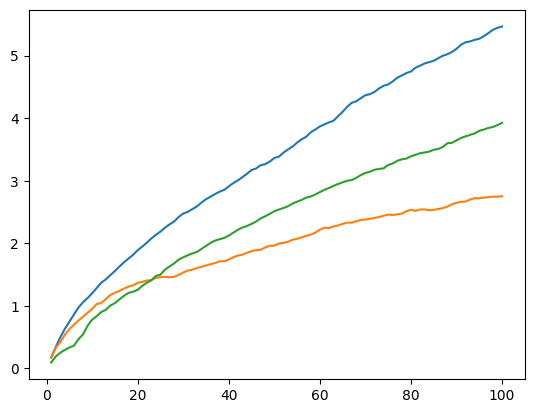

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import math

class NN(nn.Module):
  def __init__(self, input_size, num_classes):
    super(NN,self).__init__()
    self.fc1=nn.Linear(input_size,20)
    self.fc2=nn.Linear(20,50)
    self.fc3=nn.Linear(50,100)
    self.fc4=nn.Linear(100,50)
    self.fc5=nn.Linear(50,20)
    self.fc6=nn.Linear(20,num_classes)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=F.relu(self.fc3(x))
    x=F.relu(self.fc4(x))
    x=F.relu(self.fc5(x))
    x=F.softplus(self.fc6(x))
    return x

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size=1
num_classes=2
learning_rate=0.05


def UncorrBand(i,p1,p2):
    r=0
    x=random.uniform(0,1)
    if((i==1)&(x<p1)):
        r=1
    if((i==2)&(x<p2)):
       r=1
    return r

t1=0
num=1000
regsum=np.zeros(100)

while t1<num:

  model=NN(input_size=input_size,num_classes=num_classes).to(device)
  optimizer=optim.SGD(model.parameters(),lr=learning_rate)

  p1=random.uniform(0,1)
  p2=random.uniform(0,1)
  p=max(p1,p2)
  reg=np.zeros(100)

  t=0
  while t<100:
    inp=torch.ones(1,1)
    o=model(inp)
    i=torch.argmax(o)
    i=i.item()+1
    rand=random.uniform(0,1)
    if(rand<0.1):
      i=random.randint(1,2)
    r=UncorrBand(i,p1,p2)
    r=torch.tensor(r)
    loss=torch.square(r-torch.max(o))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    reg[t]=reg[t-1]+p-r
    t=t+1

  regsum=regsum+reg
  t1=t1+1

regavgnn=regsum/num
trials=range(0,100)


regsum=np.zeros(100)
n=0
while(n<num):

    a1=1
    a2=1
    b1=1
    b2=1

    p1=random.uniform(0,1)
    p2=random.uniform(0,1)
    e=max(p1,p2)

    reg=np.zeros(100)
    trial=np.zeros(100)

    t=0
    while t<100:
        x1=np.random.beta(a1,b1)
        x2=np.random.beta(a2,b2)

        if(x1>=x2):
            i=1
            r=UncorrBand(i,p1,p2)
            if(r==1):
                a1=a1+1
            else:
                b1=b1+1
        else:
            i=2
            r=UncorrBand(i,p1,p2)
            if(r==1):
                a2=a2+1
            else:
                b2=b2+1
        reg[t]=reg[t-1]+e-r
        trial[t]=trial[t-1]+1
        t=t+1
    regsum=regsum+reg
    n=n+1

regavgts=regsum/num

regsum=np.zeros(100)
l=0

while(l<num):
    p1=random.uniform(0,1)
    p2=random.uniform(0,1)
    e=max(p1,p2)

    reg=np.zeros(100)
    trial=np.zeros(100)

    x1=UncorrBand(1,p1,p2)
    x2=UncorrBand(2,p1,p2)
    n1=1
    n2=1
    n=2

    t=0
    while t<100:
        m1=x1+math.sqrt(1*math.log(n)/n1)
        m2=x2+math.sqrt(1*math.log(n)/n2)
        if(m1>=m2):
            i=1
            r=UncorrBand(i,p1,p2)
            x1=(x1*n1+r)/(n1+1)
            n1=n1+1
        else:
            i=2
            r=UncorrBand(i,p1,p2)
            x2=(x2*n2+r)/(n2+1)
            n2=n2+1
        n=n+1
        reg[t]=reg[t-1]+e-r
        trial[t]=trial[t-1]+1
        t=t+1
    regsum=regsum+reg
    l=l+1

regavgucb=regsum/num
plt.plot(trial,regavgnn)
plt.plot(trial,regavgts)
plt.plot(trial,regavgucb)
plt.show()


